In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cpu",
  torch_dtype=torch.bfloat16,
)

#df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df = pd.read_csv("BTC-USD.csv")
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["Close"])
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


/Users/ivo/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


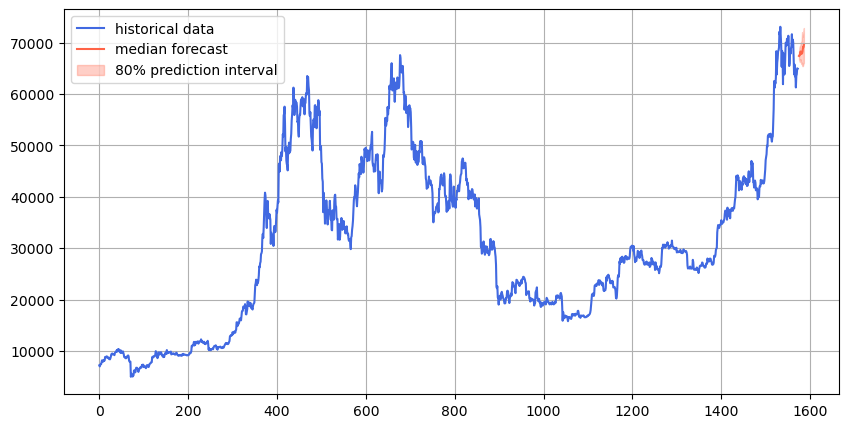

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()


/Users/ivo/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[63853.90233005 63610.18537247 64097.62325051 64463.19868689
 63975.76279028 64219.4817293  64585.05716568 64706.91564447
 64950.63260206 64463.19868689]


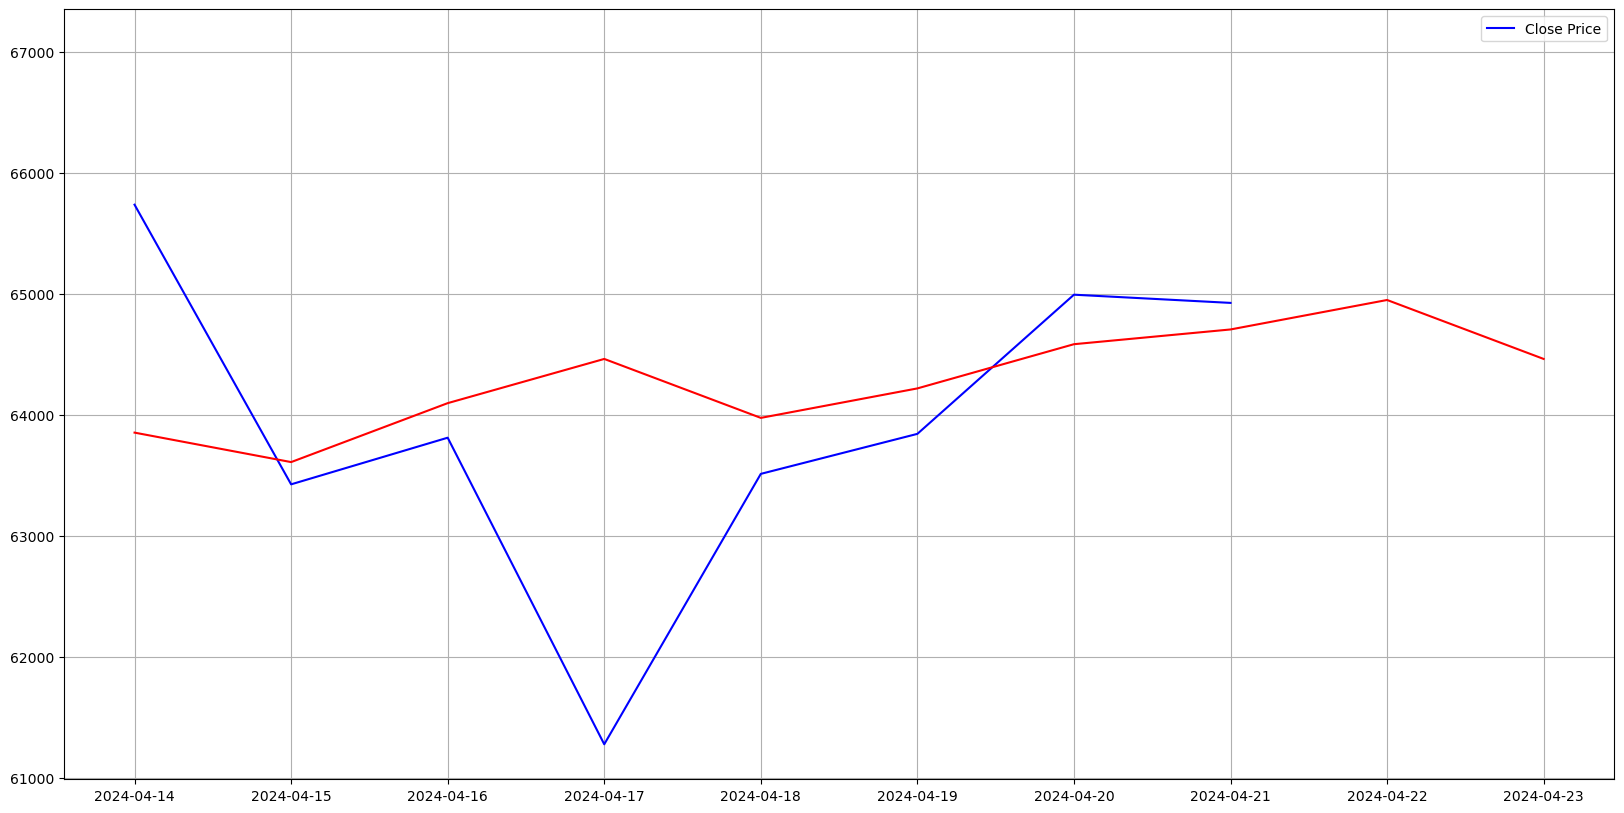

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

df = pd.read_csv("BTC-USD.csv", index_col="Date", parse_dates=True)

dias = 10

train_size = int(len(df) - dias)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]


#Hacemos las predicciones
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

prediction_length = dias
context = torch.tensor(train_df["Close"])
forecast = pipeline.predict(context, prediction_length)

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

print(median)


plt.figure(figsize=(20,10))
#plt.plot(train_df.index, train_df["Close"], label="Close Price", color="black")
plt.plot(test_df.index, test_df["Close"], label="Close Price",color="blue")
plt.plot(test_df.index, median, color="red")
plt.legend()
plt.grid(True)
plt.show()




